## 1.2 参数C的理解进阶
此时我们的虚线超平面$w \cdot x_i +b=1-\zeta_i$是由混杂在红色点中间的紫色点来决定的，所以此时此刻，这个紫色点就是我们的支持向量了。**所以软间隔让决定两条虚线超平面的支持向量可能是来自于同一个类别的样本点，而硬间隔的时候两条虚线超平面必须是由来自两个不同类别的支持向量决定的**。而C值会决定我们究竟是依赖红色点作为支持向量（只追求最大边界），还是我们要依赖软间隔中，混杂在红色点中的紫色点来作为支持向量（追求最大边界和判断正确的平衡）。如果C值设定比较大，那SVC可能会选择边际较小的，能够更好地分类所有训练点的决策边界，不过模型的训练时间也会更长。如果C的设定值较小，那SVC会尽量最大化边界，尽量将掉落在决策边界另一方的样本点预测正确，决策功能会更简单，但代价是训练的准确度，因为此时会有更多红色的点被分类错误。换句话说，C在SVM中的影响就像正则化参数对逻辑回归的影响。

此时此刻，所有可能影响我们的超平面的样本可能都会被定义为支持向量，所以支持向量就不再是所有压在虚线超平面上的点，而是所有可能影响我们的超平面的位置的那些混杂在彼此的类别中的点了。观察一下我们对不同数据集分类时，支持向量都有哪些？软间隔如何影响了超平面和支持向量，就一目了然了。

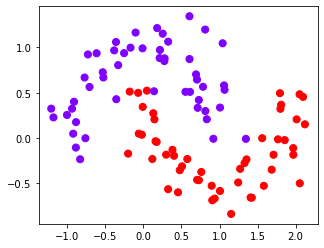

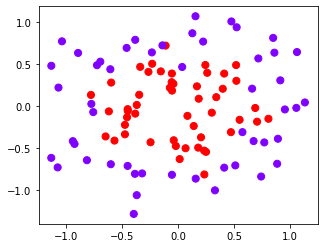

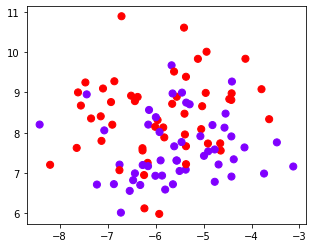

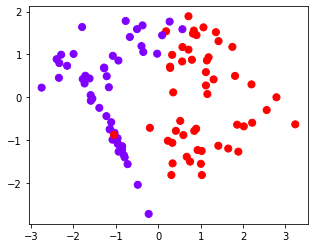

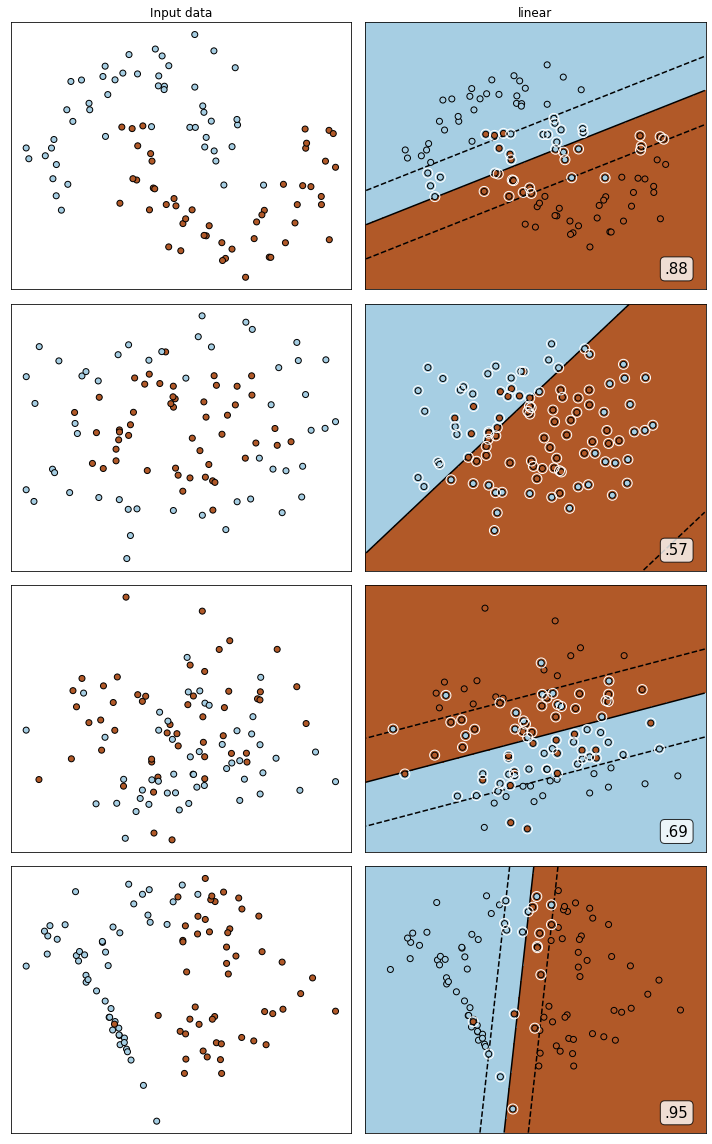

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_circles, make_moons, make_blobs, make_classification

n_samlpes = 100

datasets = [
    make_moons(n_samples=n_samlpes, noise=0.2, random_state=0),
    make_circles(n_samples=n_samlpes, noise=0.2, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samlpes, centers=2, random_state=5),
    make_classification(n_samples=n_samlpes, n_features=2, n_informative=2, n_redundant=0, random_state=5)]

Kernel = ["linear"]
#四个数据集分别是什么样子呢？
for X, Y in datasets:
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap="rainbow")

nrows = len(datasets)
ncols = len(Kernel) + 1

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 16))

#第一层循环：在不同的数据集中循环
for ds_cnt, (X, Y) in enumerate(datasets):

    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k')
    ax.set_xticks(())
    ax.set_yticks(())

    for est_idx, kernel in enumerate(Kernel):
        ax = axes[ds_cnt, est_idx + 1]

        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)

        ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, edgecolor='k')
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100, facecolors='none'
                   , zorder=10, edgecolor='white')

        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, shading='auto')
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=["--", "-", "--"],
                   levels=[-1, 0, 1])
        ax.set_xticks(())
        ax.set_yticks(())

        if ds_cnt == 0:
            ax.set_title(kernel)

        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0'),
                size=15,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'),
                transform=ax.transAxes,
                horizontalalignment='right')

plt.tight_layout()
plt.show()

**白色圈圈出的就是我们的支持向量**，大家可以看到，所有在两条虚线超平面之间的点，和虚线超平面外，但属于另一个类别的点，都被我们认为是支持向量。并不是因为这些点都在我们的超平面上，而是因为我们的超平面由所有的这些点来决定，**我们可以通过调节C来移动我们的超平面，让超平面过任何一个白色圈圈出的点**。参数C就是这样影响了我们的决策，可以说是彻底改变了支持向量机的决策过程。

## 1.3 二分类SVC中的样本不均衡问题：重要参数class_weight
对于分类问题，永远都逃不过的一个痛点就是样本不均衡问题。**样本不均衡是指在一组数据集中，标签的一类天生占有很大的比例，但我们有着捕捉出某种特定的分类的需求的状况**。比如，我们现在要对潜在犯罪者和普通人进行分类，潜在犯罪者占总人口的比例是相当低的，也许只有2%左右，98%的人都是普通人，而我们的目标是要捕获出潜在犯罪者。这样的标签分布会带来许多问题。

我们接下来就来看看如何使用这个参数。首先，我们来自建一组样本不平衡的数据集。我们在这组数据集上建两个SVC模型，一个设置有class_weight参数，一个不设置class_weight参数。我们对两个模型分别进行评估并画出他们的决策边界，以此来观察class_weight带来的效果。

1. **导入需要的库和模块**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

2. **创建样本不均衡的数据集**


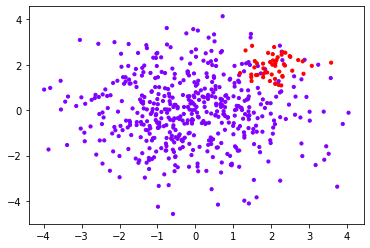

In [13]:
class_1 = 500  #类别1有500个样本
class_2 = 50  #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]]  #设定两个类别的中心
clusters_std = [1.5, 0.5]  #设定两个类别的标准差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2], centers=centers, cluster_std=clusters_std, random_state=0,
                  shuffle=False)

# 看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="rainbow")
plt.show()
#其中红色点是少数类，紫色点是多数类

3. **在数据集上分别建模**

In [14]:
# 不设定class_weight
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# 设定class_weight：0表示多数类，1表示少数类
wclf = svm.SVC(kernel='linear', class_weight={1: 10})  #将class_2的权重调整到10，即是class_1的权重的10倍
wclf.fit(X, y)

# 给两个模型分别打分看看，这个分数是accuracy准确度
clf.score(X, y), wclf.score(X, y)
# 做样本均衡之后，模型的准确度下降了，但是我们捕捉少数类的能力大大增强了

(0.9418181818181818, 0.9127272727272727)

4. **绘制两个模型下数据的决策边界**

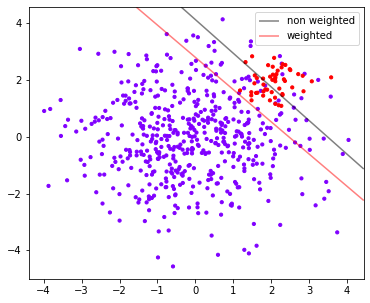

In [15]:
# 首先要有数据的分布
plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="rainbow")
ax = plt.gca()  #获取当前的子图，如果不存在，则创建新的子图

# 绘制决策边界第一步：创建网格
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

# 第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[0], alpha=0.5, linestyles=['-'])

Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[0], alpha=0.5, linestyles=['-'])

# 第三步：画图例
plt.legend([a.collections[0], b.collections[0]], ["non weighted", "weighted"],
           loc="upper right")
plt.show()

图例这一步是怎么做的？

In [24]:
a.collections  #调用这个等高线对象中画的所有线，返回一个惰性对象
# <a list of 1 LineCollection objects>
#用[*]把它打开试试看
[*a.collections]  #返回了一个Linecollection对象，其实就是我们等高线里所有的线的列表
# [<matplotlib.collections.LineCollection at 0x16252c9eeb0>]
#现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]
# <matplotlib.collections.LineCollection at 0x16252c9eeb0>
#plt.legend([对象列表],[图例列表],loc)
#只要对象列表和图例列表相对应，就可以显示出图例

从图像上可以看出，灰色是我们做样本平衡之前的决策边界。灰色线上方的点被分为一类，下方的点被分为另一类。可以看到，大约有一半少数类（红色）被分错，多数类（紫色点）几乎都被分类正确了。红色是我们做样本平衡之后的决策边界，同样是红色线上方一类，红色线下方一类。可以看到，做了样本平衡后，少数类几乎全部都被分类正确了，但是多数类有许多被分错了。我们来看看两种情况下模型的准确率如何表现：

In [16]:
#给两个模型分别打分看看，这个分数是accuracy准确度
#做样本均衡之后，我们的准确率下降了，没有样本均衡的准确率更高
clf.score(X, y), wclf.score(X, y)

(0.9418181818181818, 0.9127272727272727)

可以看出，从准确率的角度来看，不做样本平衡的时候准确率反而更高，做了样本平衡准确率反而变低了，**这是因为做了样本平衡后，为了要更有效地捕捉出少数类，模型误伤了许多多数类样本，而多数类被分错的样本数量>少数类被分类正确的样本数量，使得模型整体的精确性下降**。现在，如果我们的目的是模型整体的准确率，那我们就要拒绝样本平衡，使用class_weight被设置之前的模型。

然而在现实中，我们往往都在追求捕捉少数类，因为在很多情况下，将少数类判断错的代价是巨大的。比如我们之前提到的，判断潜在犯罪者和普通人的例子，如果我们没有能够识别出潜在犯罪者，那么这些人就可能去危害社会，造成恶劣影响，但如果我们把普通人错认为是潜在犯罪者，我们也许只是需要增加一些监控和人为甄别的成本。所以对我们来说，我们宁愿把普通人判错，也不想放过任何一个潜在犯罪者。**==我们希望不惜一切代价来捕获少数类，或者希望捕捉出尽量多的少数类，那我们就必须使用class_weight设置后的模型==**。

# 2 SVC的模型评估指标
从上一节的例子中可以看出，如果我们的目标是希望尽量捕获少数类，那准确率这个模型评估逐渐失效，所以我们需要新的模型评估指标来帮助我们。如果简单来看，其实我们只需要查看模型在少数类上的准确率就好了，只要能够将少数类尽量捕捉出来，就能够达到我们的目的。

但此时，新问题又出现了，我们对多数类判断错误后，会需要人工甄别或者更多的业务上的措施来一一排除我们判断错误的多数类，这种行为往往伴随着很高的成本。比如银行在判断”一个申请信用卡的客户是否会出现违约行为“的时候，如果一个客户被判断为”会违约“，这个客户的信用卡申请就会被驳回，如果为了捕捉出”会违约“的人，大量地将”不会违约“的客户判断为”会违约“的客户，就会有许多无辜的客户的申请被驳回。信用卡对银行来说意味着利息收入，而拒绝了许多本来不会违约的客户，对银行来说就是巨大的损失。同理，大众汽车公司在召回不符合欧盟标准的汽车时，如果为了找到所有不符合标准的汽车，而将一堆本来符合标准了的汽车召回，这个成本是不可估量的。

也就是说，单纯地追求捕捉出少数类，就会成本太高，而不顾及少数类，又会无法达成模型的效果。所以在现实中，我们往往在**寻找捕获少数类的能力和将多数类判错后需要付出的成本的平衡**。如果一个模型在能够尽量捕获少数类的情况下，还能够尽量对多数类判断正确，则这个模型就非常优秀了。为了评估这样的能力，我们将引入新的模型评估指标：**混淆矩阵和ROC曲线**。

## 2.1 混淆矩阵
**混淆矩阵是二分类问题的多维衡量指标体系，在样本不平衡时极其有用。在混淆矩阵中，我们将少数类认为是正例，多数类认为是负例**。在决策树，随机森林这些普通的分类算法里，即是说少数类是1，多数类是0。在SVM里，就是说少数类是1，多数类是-1。普通的混淆矩阵，一般使用{0,1}来表示。混淆矩阵阵如其名，十分容易让人混淆，在许多教材中，混淆矩阵中各种各样的名称和定义让大家难以理解难以记忆。一种简化的方式来显示标准二分类的混淆矩阵，如图所示：

混淆矩阵中，永远是真实值在前，预测值在后。其实可以很容易看出，11和00的对角线就是全部预测正确的，01和10的对角线就是全部预测错误的。基于混淆矩阵，我们有六个不同的模型评估指标，这些评估指标的范围都在[0,1]之间，**所有以11和00为分子的指标都是越接近1越好，所以以01和10为分子的指标都是越接近0越好**。对于所有的指标，我们用橙色表示分母，用绿色表示分子，则我们有：

### 2.1.1 模型整体效果：准确率
**准确率Accuracy**就是所有预测正确的所有样本除以总样本，通常来说越接近1越好。

### 2.1.2 捕捉少数类的艺术：精确度，召回率和F1 score

**==精确度Precision==**，又叫查准率，表示所有被我们预测为是少数类的样本中，真正的少数类所占的比例。在支持向量机中，精确度可以被形象地表示为决策边界上方的所有点中，红色点所占的比例。精确度越高，代表我们捕捉正确的红色点越多，对少数类的预测越精确。精确度越低，则代表我们误伤了过多的多数类。**精确度是”将多数类判错后所需付出成本“的衡量**。

In [24]:
# 精确度(Precision)：正确判断为1的样本/所有被判断为1的样本

# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum() / (clf.predict(X) == 1).sum()  # 0.7142857142857143

# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum() / (wclf.predict(X) == 1).sum()  # 0.5102040816326531

可以看出，做了样本平衡之后，精确度是下降的。因为很明显，样本平衡之后，有更多的多数类紫色点被我们误伤了。精确度可以帮助我们判断，是否每一次对少数类的预测都精确，所以又被称为”查准率“。在现实的样本不平衡例子中，**当每一次将多数类判断错误的成本非常高昂的时候（比如大众召回车辆的例子），我们会追求高精确度**。精确度越低，我们对多数类的判断就会越错误。当然了，**如果我们的目标是不计一切代价捕获少数类，那我们并不在意精确度**。

**==召回率Recall==**，又被称为敏感度(sensitivity)，真正率，查全率，表示所有真实为1的样本中，被我们预测正确的样本所占的比例。在支持向量机中，召回率可以被表示为，决策边界上方的所有红色点占全部样本中的红色点的比例。召回率越高，代表我们尽量捕捉出了越多的少数类，召回率越低，代表我们没有捕捉出足够的少数类。

In [27]:
# 召回率(Recall)：正确判断为1的样本/所有真实为1的样本

# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 1).sum() / (y == 1).sum()  # 0.6

# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 1).sum() / (y == 1).sum()  # 1.0

可以看出，做样本平衡之前，我们只成功捕获了60%的少数类点，而做了样本平衡之后的模型，捕捉出了100%的少数类点，从图像上来看，我们的红色决策边界的确捕捉出了全部的少数类，而灰色决策边界只捕捉到了一半左右。**召回率可以帮助我们判断，我们是否捕捉除了全部的少数类，所以又叫做查全率**。

**如果我们希望不计一切代价，找出少数类（比如找出潜在犯罪者的例子），那我们就会追求高召回率**，相反如果我们的目标不是尽量捕获少数类，那我们就不需要在意召回率。

注意召回率和精确度的分子是相同的（都是11），只是分母不同。而**召回率和精确度是此消彼长的，两者之间的平衡代表了捕捉少数类的需求和尽量不要误伤多数类的需求的平衡**。究竟要偏向于哪一方，取决于我们的业务需求：究竟是误伤多数类的成本更高，还是无法捕捉少数类的代价更高。

为了同时兼顾精确度和召回率，我们创造了两者的调和平均数作为考量两者平衡的综合性指标，称之为**==F1 measure==**。两个数之间的调和平均倾向于靠近两个数中比较小的那一个数，因此我们追求尽量高的F1 measure，能够保证我们的精确度和召回率都比较高。F1measure在[0,1]之间分布，越接近1越好。
$$F-measure = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall}
$$

从Recall延申出来的另一个评估指标叫做**假负率（FalseNegativeRate）**，它等于1-Recall，用于衡量所有真实为1的样本中，被我们错误判断为0的，通常用得不多。
$$FNR = \frac{10}{11 + 10} = 1 - Recall
$$

### 2.1.3 判错多数类的考量：特异度与假正率
**特异度Specificity**表示所有真实为0的样本中，被正确判断为0的样本所占的比例(有点类似多数类的召回率)。在支持向量机中，可以形象地表示为，决策边界下方紫色的点占所有紫色点的比例。

In [30]:
# 特异度(Specificity)：正确判断为0的样本/所有真实为0的样本

# 对于没有class_weight，没有做样本平衡的灰色决策边界来说：
(y[y == clf.predict(X)] == 0).sum() / (y == 0).sum()  # 0.976

# 对于有class_weight，做了样本平衡的红色决策边界来说：
(y[y == wclf.predict(X)] == 0).sum() / (y == 0).sum()  # 0.904

**特异度衡量了一个模型将多数类判断正确的能力，而1-specificity就是衡量一个模型将多数类判断错误的能力**，这种能力被计算如下，并叫做**假正率（FalsePositiveRate）**：

**在支持向量机中，假正率就是决策边界上方的紫色点（所有被判断错误的多数类）占所有紫色点的比例**。根据我们之前在精确度Precision处的分析，其实可以看得出来，当样本均衡过后，假正率会更高，因为有更多紫色点被判断错误，而样本均衡之前，假正率比较低，被判错的紫色点比较少。所以假正率其实类似于Precision的反向指标，Precision衡量有多少少数点被判断正确，而假正率FPR衡量有多少多数点被判断错误，性质是十分类似的。

### 2.1.4 sklearn中的混淆矩阵
sklearn当中提供了大量的类来帮助我们了解和使用混淆矩阵。

## 2.2 ROC曲线以及其相关问题
基于混淆矩阵，我们学习了总共六个指标：准确率Accuracy，精确度Precision，召回率Recall，精确度和召回度的平衡指标F measure，特异度Specificity，以及假正率FPR。

其中，假正率有一个非常重要的应用：我们在追求较高的Recall的时候，Precision会下降，就是说随着更多的少数类被捕捉出来，会有更多的多数类被判断错误，但我们很好奇，随着Recall的逐渐增加，模型将多数类判断错误的能力如何变化呢？我们希望理解，我每判断正确一个少数类，就有多少个多数类会被判断错误。假正率正好可以帮助我们衡量这个能力的变化。相对的，Precision无法判断这些判断错误的多数类在全部多数类中究竟占多大的比例，所以无法在提升Recall的过程中也顾及到模型整体的Accuracy。因此，我们可以使用Recall和FPR之间的平衡，来替代Recall和Precision之间的平衡，让我们**衡量模型在尽量捕捉少数类的时候，误伤多数类的情况如何变化**，这就是我们的ROC曲线衡量的平衡。

ROC曲线，全称The Receiver Operating Characteristic Curve，译为受试者操作特性曲线。这是一条以不同阈值下的假正率FPR为横坐标，不同阈值下的召回率Recall为纵坐标的曲线。让我们先从概率和阈值开始讲起。

### 2.2.1 概率(probability)与阈值(threshold)
要理解概率与阈值，想一下逻辑回归做分类的时候的状况。逻辑回归的predict_proba接口对每个样本生成每个标签类别下的似然（类概率）。对于这些似然，逻辑回归天然规定，当一个样本所对应的这个标签类别下的似然大于0.5的时候，这个样本就被分为这一类。比如说，一个样本在标签1下的似然是0.6，在标签0下的似然是0.4，则这个样本的标签自然就被分为1。逻辑回归的回归值本身，其实也就是标签1下的似然。在这个过程中，0.5就被称为阈值。下面的例子帮你理解概率和阈值的概念：

1. 自建数据集


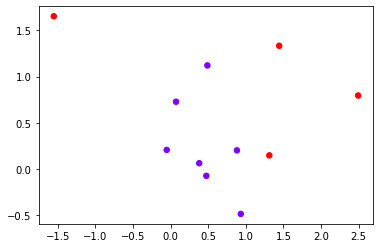

In [33]:
class_1 = 7
class_2 = 4
centers = [[0.0, 0.0], [1, 1]]
clusters_std = [0.5, 1]
X_, y_ = make_blobs(n_samples=[class_1, class_2],
                    centers=centers,
                    cluster_std=clusters_std,
                    random_state=0, shuffle=False)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap="rainbow", s=30)
plt.show()

2. 建模，调用概率

In [37]:
from sklearn.linear_model import LogisticRegression as LogiR

clf_lo = LogiR().fit(X_, y_)
# prob是一个n行k列的数组，第i行第j列上的数值是模型预测第i个样本的标签为j的概率
prob = clf_lo.predict_proba(X_)

# 将样本和概率放在一个DataFrame中，进行查看
import pandas as pd

prob = pd.DataFrame(prob)

prob.columns = ["0", "1"]

prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


3. 使用阈值0.5，大于0.5的样本被预测为1，小于0.5的样本被预测为0

In [40]:
# 手动调节阈值，来观察阈值对模型的影响
for i in range(prob.shape[0]):
    if prob.loc[i, "1"] > 0.5:
        prob.loc[i, "pred"] = 1
    else:
        prob.loc[i, "pred"] = 0
prob["y_true"] = y_  # 增加一列，真实标签
prob = prob.sort_values(by="1", ascending=False)  # 按照预测为1的概率降序排列
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,0.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


4. 使用混淆矩阵查看结果

In [43]:
from sklearn.metrics import confusion_matrix as CM, recall_score as R, precision_score as P

# 生成混淆矩阵，labels=[1, 0]表示混淆矩阵的第一行对应正类标签为1，第一列对应正类标签为1，第二行对应负类标签为0，第二列对应负类标签为0
CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

array([[2, 2],
       [0, 7]], dtype=int64)

In [45]:
# 试试看手动计算一下精确率和召回率？
2 / (2 + 0), 2 / (2 + 2)

(1.0, 0.5)

In [46]:
# 使用sklearn自带的函数来计算精确率和召回率
print(P(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0]))
print(R(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0]))
# 可见和手动计算的结果是一样的

1.0
0.5


5. 假如我们使用0.4作为阈值呢？

In [47]:
#假如我们使用0.4作为阈值呢？
for i in range(prob.shape[0]):
    if prob.loc[i, "1"] > 0.4:
        prob.loc[i, "pred"] = 1
    else:
        prob.loc[i, "pred"] = 0
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [48]:
CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

array([[2, 2],
       [1, 6]], dtype=int64)

In [49]:
print(P(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0]))
print(R(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0]))
# 注意，降低或者升高阈值并不一定能够让模型的效果变好，一切都基于我们要追求怎样的模型效果
# 通常来说，降低阈值会提高召回率Recall，但不是绝对的

0.6666666666666666
0.5


可见，在不同阈值下，我们的模型评估指标会发生变化，我们正利用这一点来观察Recall和FPR之间如何互相影响。**但是注意，并不是升高阈值，就一定能够增加或者减少Recall，一切要根据数据的实际分布来进行判断**。而要体现阈值的影响，首先必须得到分类器在少数类下的预测概率。对于逻辑回归这样天生生成似然的算法和朴素贝叶斯这样就是在计算概率的算法，自然非常容易得到概率，但对于一些其他的分类算法，比如决策树，比如SVM，他们的分类方式和概率并不相关。那在他们身上，我们就无法画ROC曲线了吗？并非如此。

决策树有叶子节点，一个叶子节点上可能包含着不同类的样本。假设一个样本被包含在叶子节点a中，节点a包含10个样本，其中6个为1，4个为0，则1这个正类在这个叶子节点中的出现概率就是60%，类别0在这个叶子节点中的出现概率就是40%。对于所有在这个叶子节点中的样本而言，节点上的1和0出现的概率，就是这个样本对应的取到1和0的概率。但是思考一个问题，由于决策树可以被画得很深，在足够深的情况下，决策树的每个叶子节点上可能都不包含多个类别的标签了，可能一片叶子中只有唯一的一个标签，即叶子节点的不纯度为0，此时此刻，对于每个样本而言，他们所对应的“概率”就是0或者1了。这个时候，我们就无法调节阈值来调节我们的Recall和FPR了。对于随机森林，也是如此。

**所以，如果我们有概率需求，我们还是会优先追求逻辑回归或者朴素贝叶斯。不过其实，SVM也可以生成概率**，我们一起来看看，它是怎么做的。

### 2.2.2 SVM实现概率预测：重要参数probability，接口predict_proba以及decision_function
我们在画等高线，也就是决策边界的时候曾经使用SVC的接口decision_function，它返回我们输入的特征矩阵中每个样本到划分数据集的超平面的距离。我们在SVM中利用超平面来判断我们的样本，本质上来说，当两个点的距离是相同的符号的时候，越远离超平面的样本点归属于某个标签类的概率就很大。比如说，一个距离超平面0.1的点，和一个距离超平面100的点，明显是距离为0.1的点更有可能是负类别的点混入了边界。同理，一个距离超平面距离为-0.1的点，和一个离超平面距离为-100的点，明显是-100的点的标签更有可能是负类。所以，**到超平面的距离一定程度上反应了样本归属于某个标签类的可能性。接口decision_function返回的值也因此被我们认为是SVM中的置信度（confidence）**。

不过，置信度始终不是概率，它没有边界，可以无限大，大部分时候也不是以百分比或者小数的形式呈现，而SVC的判断过程又不像决策树一样可以求解出一个比例。为了解决这个矛盾，SVC有重要参数probability。

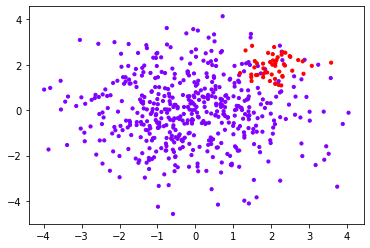

In [50]:
# 使用最初的X和y，样本不均衡的这个模型

class_1 = 500  #类别1有500个样本
class_2 = 50  #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]]  #设定两个类别的中心
clusters_std = [1.5, 0.5]  #设定两个类别的标准差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2], centers=centers, cluster_std=clusters_std, random_state=0,
                  shuffle=False)

# 看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="rainbow")
plt.show()
#其中红色点是少数类，紫色点是多数类

In [56]:
clf_proba = svm.SVC(kernel="linear", C=1.0, probability=True).fit(X, y)

clf_proba.predict_proba(X)  # 返回的是一个n行2列的数组，第i行第j列的数值是模型预测第i个预测样本的标签为j的概率

clf_proba.predict_proba(X).shape  # (550,2)

clf_proba.decision_function(X)  # 返回的是每个输入样本到决策边界的距离(有正负)

clf_proba.decision_function(X).shape  # (500,)

(550,)

值得注意的是，在二分类过程中，decision_function只会生成一列距离，样本的类别由距离的符号来判断，但是predict_proba会生成两个类别分别对应的概率。SVM也可以生成概率，所以我们可以使用和逻辑回归同样的方式来在SVM上设定和调节我们的阈值。

毋庸置疑，Platt缩放中涉及的交叉验证对于大型数据集来说非常昂贵，计算会非常缓慢。另外，由于Platt缩放的理论原因，在二分类过程中，有可能出现predict_proba返回的概率小于0.5，但样本依旧被标记为正类的情况出现，毕竟支持向量机本身并不依赖于概率来完成自己的分类。如果我们的确需要置信度分数，但不一定非要是概率形式的话，那建议可以将probability设置为False，使用decision_function这个接口而不是predict_proba。

### 2.2.3 绘制SVM的ROC曲线
现在，我们理解了什么是阈值（threshold），了解了不同阈值会让混淆矩阵产生变化，也了解了如何从我们的分类算法中获取概率。现在，我们就可以开始画我们的ROC曲线了。**ROC是一条以不同阈值下的假正率FPR为横坐标，不同阈值下的召回率Recall为纵坐标的曲线**。简单地来说，只要我们有数据和模型，我们就可以在python中绘制出我们的ROC曲线。思考一下，我们要绘制ROC曲线，就必须在我们的数据中去不断调节阈值，不断求解混淆矩阵，然后不断获得我们的横坐标和纵坐标，最后才能够将曲线绘制出来。接下来，我们就来执行这个过程：

首先来看看如何从混淆矩阵中获取FPR和Recall

In [ ]:
# 生成一个混淆矩阵
cm = CM(prob.loc[:, "y_true"], prob.loc[:, "pred"], labels=[1, 0])

# 根据混淆矩阵计算FRP和Recall
print(cm[1, 0] / cm[1, :].sum(), cm[0, 0] / cm[0, :].sum())

开始绘图：

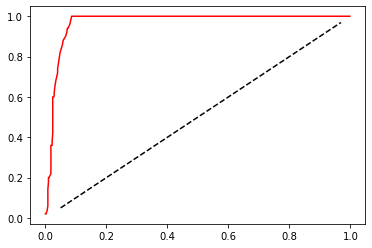

In [76]:
recall = []
FPR = []
# 设定50个阈值
probrange = np.linspace(clf_proba.predict_proba(X)[:, 1].min(),
                        clf_proba.predict_proba(X)[:, 1].max(),
                        num=50,
                        endpoint=False)  # endpoint=False表示不包含最大值

from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plt

for i in probrange:
    y_predict = []
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j, 1] > i:
            y_predict.append(1)
        else:
            y_predict.append(0)
    cm = CM(y, y_predict, labels=[1, 0])
    recall.append(cm[0, 0] / cm[0, :].sum())
    FPR.append(cm[1, 0] / cm[1, :].sum())

recall.sort()
FPR.sort()

plt.plot(FPR, recall, c="red")
plt.plot(probrange + 0.05, probrange + 0.05, c="black", linestyle="--")
plt.show()

现在我们就画出了ROC曲线了，那我们如何理解这条曲线呢？先来回忆一下，我们**建立ROC曲线的根本目的是找寻Recall和FPR之间的平衡，让我们能够衡量模型在尽量捕捉少数类的时候，误伤多数类的情况会如何变化**。横坐标是FPR，代表着模型将多数类判断错误的能力，纵坐标Recall，代表着模型捕捉少数类的能力，所以ROC曲线代表着，随着Recall的不断增加，FPR如何增加。**我们希望随着Recall的不断提升，FPR增加得越慢越好，这说明我们可以尽量高效地捕捉出少数类，而不会将很多地多数类判断错误**。所以，我们希望看到的图像是，纵坐标急速上升，横坐标缓慢增长，也就是在整个图像左上方的一条弧线。这代表模型的效果很不错，拥有较好的捕获少数类的能力

中间的虚线代表着，当recall增加1%，我们的FPR也增加1%，也就是说，我们每捕捉出一个少数类，就会有一个多数类被判错，这种情况下，模型的效果就不好，这种模型捕获少数类的结果，会让许多多数类被误伤，从而增加我们的成本。ROC曲线通常都是凸型的。**对于一条凸型ROC曲线来说，曲线越靠近左上角越好，越往下越糟糕**，曲线如果在虚线的下方，则证明模型完全无法使用。但是它也有可能是一条凹形的ROC曲线。**对于一条凹型ROC曲线来说，应该越靠近右下角越好，凹形曲线代表模型的预测结果与真实情况完全相反**，那也不算非常糟糕，只要我们手动将模型的结果逆转，就可以得到一条左上方的弧线了。**最糟糕的就是，无论曲线是凹形还是凸型，曲线位于图像中间，和虚线非常靠近，那我们拿它无能为力**。

好了，现在我们有了这条曲线，我们的确知道模型的效果还算是不错了。但依然非常摸棱两可，有没有具体的数字来帮助我们理解ROC曲线和模型的效果呢？的确存在，这个数字就叫做**AUC面积，它代表了ROC曲线下方的面积**，这个面积越大，代表ROC曲线越接近左上角，模型就越好。AUC面积的计算比较繁琐，因此，我们使用sklearn来帮助我们。接下来我们来看看，在sklearn当中，如何绘制我们的ROC曲线，找出我们的的AUC面积。


### 2.2.4 sklearn中的ROC曲线和AUC面积
在sklearn中，我们有帮助我们计算ROC曲线的横坐标假正率FPR，纵坐标Recall和对应的阈值的类 sklearn.metrics.roc_curve。同时，我们还有帮助我们计算AUC面积的类sklearn.metrics.roc_auc_score。在一些 比较老旧的sklearn版本中，我们使用sklearn.metrics.auc这个类来计算AUC面积，但这个类在0.22版本中被放弃，因此建议大家都使用roc_auc_score。来看看我们的这两个类：

`sklearn.metrics.roc_curve (y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)`

 - y_true : 数组，形状 = [n_samples]，真实标签
 - y_score : 数组，形状 = [n_samples]，可以是正类样本的概率值，或置信度分数，或decision_function返回的距离
 - pos_label : 整数或者字符串, 默认None，表示被认为是正类样本的类别
 - sample_weight : 形如 [n_samples]的类数组结构，可不填，表示样本的权重
 - drop_intermediate : 布尔值，默认True，如果设置为True，表示会舍弃一些ROC曲线上不显示的阈值点，这对于计算一个比较轻量的ROC曲线来说非常有用

这个类返回：FPR，Recall以及阈值。

`sklearn.metrics.roc_auc_score (y_true, y_score, average=’macro’, sample_weight=None, max_fpr=None)`

AUC面积的分数使用上类来进行计算，输入的参数也比较简单，就是真实标签，和与roc_curve中一致的置信度分数或者概率值。

怎么使用？

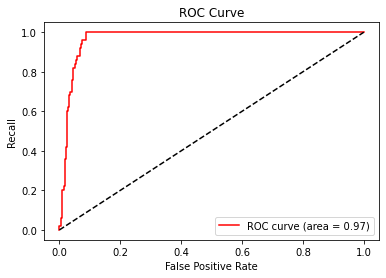

In [98]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf_proba = svm.SVC(kernel="linear", C=1.0, probability=True).fit(X, y)
# 此时这里的thresholds就不是我们之前的概率值了，而是距离值中的阈值，所以它可以大于1，也可以小于0
FPR, recall, thresholds = roc_curve(y, clf_proba.decision_function(X), pos_label=1)
auc_score = roc_auc_score(y, clf_proba.decision_function(X))  # 0.9696400000000001

# 画图
plt.figure()
plt.plot(FPR, recall, color='red', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

如此就得到了我们的ROC曲线和AUC面积，可以看到，SVM在这个简单数据集上的效果还是非常好的。并且可以通过观察我们使用decision_function画出的ROC曲线，对比一下我们之前强行使用概率画出来的曲线，两者非常相似，所以在无法获取模型概率的情况下，其实不必强行使用概率，如果有置信度，那也使可以完成我们的ROC曲线的。g感兴趣的可以画一下如果带上class_weight这个参数，模型的效果会变得如何(我反正啥也没变化)。

### 2.2.5 利用ROC曲线找出最佳阈值
现在，有了ROC曲线，了解了模型的分类效力，以及面对样本不均衡问题时的效力，那我们如何求解我们最佳的阈值呢？我们想要了解，什么样的状况下我们的模型的效果才是最好的。回到我们对ROC曲线的理解来：**ROC曲线反映的是recall增加的时候FPR如何变化，也就是当模型捕获少数类的能力变强的时候，会误伤多数类的情况是否严重**。我们的希望是，模型在捕获少数类的能力变强的时候，尽量不误伤多数类，也就是说，随着recall的变大，FPR的值越小越好。所以我们希望找到的阈值最优点，其实是Recall和FPR差距最大的点。这个点，又叫做**约登指数**。

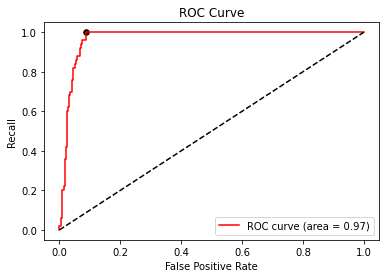

In [108]:
# 差值最大的点的索引
maxindex = (recall - FPR).tolist().index((recall - FPR).max())
# 差值最大的点对应的阈值
th = thresholds[maxindex]

# 我们可以可以在图像上看一下这个点在哪里
plt.figure()
plt.plot(FPR, recall, color='red', label='ROC curve (area = %0.2f)' % auc_score)
plt.scatter(FPR[maxindex], recall[maxindex], color='black', s=30)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

最佳阈值就这样选取出来了，由于现在我们是使用decision_function来画ROC曲线，所以我们选择出来的最佳阈值其实是最佳距离。如果我们使用的是概率，我们选取的最佳阈值就会使一个概率值了。**只要我们让这个距离/概率以上的点，都为正类，让这个距离/概率以下的点都为负类，模型就是最好的：即能够捕捉出少数类，又能够尽量不误伤多数类，整体的精确性和对少数类的捕捉都得到了保证**。而从找出的最优阈值点来看，这个点，其实是图像上离左上角最近的点，离中间的虚线最远的点，也是ROC曲线的转折点。如果没有时间进行计算，或者横坐标比较清晰的时候，我们就可以观察转折点来找到我们的最佳阈值。到这里为止，SVC的模型评估指标就介绍完毕了。但是，SVC的样本不均衡问题还可以有很多的探索。另外，我们还可以使用KS曲线，或者收益曲线(profitchart)来选择我们的阈值，都是和ROC曲线类似的用法。大家若有余力，可以自己深入研究一下。模型评估指标，还有很多深奥的地方。

# 3 SVC的重要属性
到目前为止，SVC的几乎所有重要参数，属性和接口我们都已经介绍完毕了。在这里，给大家做一个查缺补漏：

In [117]:
# 属性n_support_：返回每一个类别的支持向量的个数
clf_proba.n_support_

# 属性coef_：每个特征的重要性系数，只有在核函数为线性的时候才有意义
clf_proba.coef_

# 属性intercept_：决策边界的截距
clf_proba.intercept_

# 属性dual_coef_：生成的拉格朗日乘数
clf_proba.dual_coef_
clf_proba.dual_coef_.shape

# 支持向量的坐标
clf_proba.support_vectors_
clf_proba.support_vectors_.shape

#注意到dual_coef_中生成的拉格朗日乘数的数目和我们的支持向量的数目一致
#注意到KKT条件的条件中的第五条，所有非支持向量会让拉格朗日乘数为0
#所以拉格朗日乘数的数目和支持向量的数目是一致的
#注意，此情况仅仅在二分类中适用！